Parameter Heatmap
==========

This tutorial will show how to optimize strategies with multiple parameters and how to examine and reason about optimization results.
It is assumed you're already familiar with
[basic _backtesting.py_ usage](https://kernc.github.io/backtesting.py/doc/examples/Quick Start User Guide.html).

First, let's again import our helper moving average function.
In practice, one can use functions from any indicator library, such as
[TA-Lib](https://github.com/mrjbq7/ta-lib),
[Tulipy](https://tulipindicators.org),
PyAlgoTrade, ...

In [1]:
from backtesting.test import SMA

Loading BokehJS ...

Our strategy will be a similar moving average cross-over strategy to the one in
[Quick Start User Guide](https://kernc.github.io/backtesting.py/doc/examples/Quick Start User Guide.html),
but we will use four moving averages in total:
two moving averages whose relationship determines a general trend
(we only trade long when the shorter MA is above the longer one, and vice versa),
and two moving averages whose cross-over with Close prices determine the signal to enter or exit the position.

In [2]:
from backtesting import Strategy
from backtesting.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        
    def next(self):
        
        if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):
                
                self.position.close()

It's not a robust strategy, but we can optimize it. Let's optimize our strategy on Google stock data.

In [3]:
%%time 

from backtesting import Backtest
from backtesting.test import GOOG


backtest = Backtest(GOOG, Sma4Cross, commission=.002)

stats, heatmap = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    return_heatmap=True)

CPU times: user 585 ms, sys: 102 ms, total: 687 ms
Wall time: 11.7 s


Notice `return_heatmap=True` parameter passed to
[`Backtest.optimize()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize).
It makes the function return a heatmap series along with the usual stats of the best run.
`heatmap` is a pandas Series indexed with a MultiIndex, a cartesian product of all permissible parameter values.
The series values are from the `maximize=` argument we provided.

In [15]:
heatmap

n_exit  n_enter  n2   n1 
10      15       40   20      8742.77
                      30     10662.30
                 60   20     10020.29
                      30     11386.84
                      40     13179.02
                      50      8903.43
                 80   20      9877.11
                      30      8675.47
                      40      9671.30
                      50     12621.72
                      60     12754.77
                      70     15869.19
                 100  20     11005.88
                      30     10293.02
                      40     12212.70
                               ...   
20      30       160  100     9392.84
                 180  40      8080.16
                      50      8080.16
                      60      8080.16
                      70      7727.38
                      80      7727.38
                      90      7727.38
                      100     7727.25
                 200  40      7923.41
                      50

This heatmap contains the results of all the runs,
making it very easy to obtain parameter combinations for e.g. three best runs:

In [5]:
heatmap.sort_values().iloc[-3:]

n_exit  n1  n_enter  n2 
15      40  25       60     21137.84
        50  20       120    22012.50
        40  20       160    22644.29
dtype: float64

But people have this enormous faculty of vision, used to make judgements on much larger data sets much faster.
Let's plot the whole heatmap by projecting it on two chosen dimensions.
Say we're mostly interested in how parameters `n1` and `n2`, on average, affect the outcome.

In [6]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2,40,60,80,100,120,140,160,180,200
n1,,,,,,,,,
20,8742.77,10020.29,9877.11,11005.88,12832.05,12115.57,13380.55,9462.92,9993.13
30,11685.45,11947.24,12507.64,13247.98,12471.19,10955.33,12672.70,11049.38,10599.47
40,NaN,14522.63,11314.04,8852.70,11252.55,9538.35,12615.52,10804.31,10094.83
50,NaN,9268.08,10761.43,11780.65,11928.56,10022.42,11639.78,10783.37,9737.71
60,NaN,NaN,9901.77,11012.14,9550.52,10839.21,11360.96,10512.38,9653.58
70,NaN,NaN,11015.24,9408.20,9828.18,10759.51,11366.77,9972.34,8627.18
80,NaN,NaN,NaN,10148.83,10225.92,10272.49,11111.84,10230.37,9560.67
90,NaN,NaN,NaN,11175.10,11240.16,10239.04,11171.33,10561.55,10258.52
100,NaN,NaN,NaN,NaN,11954.44,9413.20,11689.47,10094.51,10564.84


Let's plot this table using the excellent [_Seaborn_](https://seaborn.pydata.org) package:

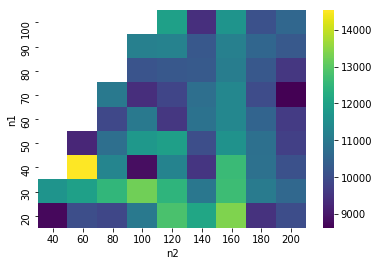

In [7]:
%matplotlib inline

import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis')

We see that, on average, we obtain the highest result using trend-determining parameters `n1=40` and `n2=60`,
and it's not like other nearby combinations work similarly well — in our particular strategy, this combination really stands out.

Since our strategy contains several parameters, we might be interested in other relationships between their values.
We can use
[`backtesting.lib.plot_heatmaps()`](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#backtesting.lib.plot_heatmaps)
function to plot interactive heatmaps of all parameter combinations simultaneously.

In [7]:
from backtesting.lib import plot_heatmaps


plot_heatmaps(heatmap, agg='mean')

Column(id='2574', ...)